In [1]:
from torch import nn
from torch import optim
import torch
import torch.utils.data as tdata
import pytorch_lightning as pl
import numpy as np
import os
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed

In [2]:
# plot by generations
from src.solver import Solver0D
from src.file_io import read_json
from collections import defaultdict

In [3]:
%matplotlib inline

# Functions 

In [41]:
def d2m(val):
    return val / 1333.22

def RAE(y, yhat):
    ''' Relative absolute error'''
    rae = abs(y - yhat).sum() / abs(y - y.mean()).sum()
    return rae
def d2m(val):
    return val / 1333.22

def RAE(y, yhat):
    ''' Relative absolute error'''
    rae = abs(y - yhat).sum() / abs(y - y.mean()).sum()
    return rae

def MaxRE(y, yhat):
    res = (abs(y - yhat) / y)
    max_re = res.max()
    return max_re

def AvgRE(y, yhat):
    res = (abs(y - yhat) / y)
    avg_re = res.mean()
    return avg_re

def model_metrics(predict_input, predict_output):
    # remove cases where predict_input < 1.0
    x, y, yhat = get_y(predict_input, predict_output)
    
    p_rae = []
    q_rae = []
    max_re = []
    mean_re = []
    for i in range(len(y[0])):
        
        if i % 2 == 0:
            p_rae.append(RAE(y[:, i], yhat[:, i]))
        else:
            q_rae.append(RAE(y[:, i], yhat[:, i]))
        max_re.append(MaxRE(y[:, i], yhat[:, i]))
        mean_re.append(AvgRE(y[:, i], yhat[:, i]))
    for p in p_rae:
        print(f"{round(p.item() * 100, 2)}%", end = ' | ')
    print()
    print('Average Pressure RAE:', f"{round(np.array(p_rae).mean() * 100, 2)}%")
    for q in q_rae:
        print(f"{round(q.item() * 100, 2)}%", end = ' | ')
    print()
    print('Average Flow RAE:', f"{round(np.array(q_rae).mean() * 100, 2)}%")
    print("Average Total RAE:", f"{round(np.array(p_rae + q_rae).mean() * 100, 2)}%")
    print("Max Relative Error:", f"{round(np.array(max_re).max() * 100, 3)}%")
    print("Avg Relative Error:", f"{round(np.array(mean_re).mean() * 100, 3)}%")
    

def plot_losses(df, ylim = .2):
    ''' loss plot '''
    fig, ax = plt.subplots(1, 1)
    ax.plot(df['step'], df['train_loss'], alpha = .8, label = 'train_loss')    
    ax.plot(df['step'], df['val_loss'], color ='r', alpha = .5, marker = '^', label = 'val_loss')
    ax.plot(df['step'], df['test_loss'], color ='k', alpha = 1, marker = 'o', label = 'test_loss')
    ax.legend()
    ax.set_ylim(0, ylim)
    ax.set_xlabel('Steps')
    ax.set_ylabel('Huber Loss')
    ax.set_title('Training Logs')
    
    results(df)
    
def results(df):
    print('Final Train Loss:', df['train_loss'].dropna().iloc[-1])
    print('Final Val Loss:', df['val_loss'].dropna().iloc[-1])
    print('Final Test Loss:', df['test_loss'].dropna().iloc[-1])
    
def plot_residuals(predict_input, predict_output, vessel):

    P_vessel = vessel * 2
    Q_vessel = vessel * 2 + 1
    residuals = predict_output[:, 1] - predict_output[:, 0]  # yhat - y
    
    fig, ax = plt.subplots(1, 2, figsize = (16, 8))
    ax[0].set_title('Residual Pressures (mmHg)')
    ax[0].set_xlabel('radius change')
    ax[0].set_ylabel('residual (mmHg)')
    ax[0].scatter(predict_input[:, vessel], d2m(residuals[:, P_vessel]))
    
    ax[1].set_title('Residual Flows (ml/s)')
    ax[1].set_xlabel('radius change')
    ax[1].set_ylabel('residual (ml/s)')
    ax[1].scatter(predict_input[:, vessel], residuals[:, Q_vessel])
    
def plot_yhat(predict_input, predict_output, vessel):

    P_vessel = vessel * 2
    Q_vessel = vessel * 2 + 1
    y = predict_output[:, 0]
    yhat = predict_output[:, 1] # yhat
    
    fig, ax = plt.subplots(1, 2, figsize = (16, 8))
    ax[0].set_title('Pressures (mmHg)')
    ax[0].set_xlabel('True Pressure')
    ax[0].set_ylabel('Predicted Pressure (mmHg)')
    ax[0].scatter(d2m(y[:, P_vessel]), d2m(yhat[:, P_vessel]), alpha = .7)
    x = np.arange(d2m(y[:, P_vessel].min()), d2m(y[:, P_vessel].max()), step = .01)
    ax[0].plot(x, x, color = 'r')
    
    ax[1].set_title('Flows (ml/s)')
    ax[1].set_xlabel('True Flow')
    ax[1].set_ylabel('Predicted Flow (ml/s)')
    ax[1].scatter(y[:, Q_vessel], yhat[:, Q_vessel], alpha = .7)
    x = np.arange(y[:, Q_vessel].min(), y[:, Q_vessel].max(), step = .01)
    ax[1].plot(x, x, color = 'r')

def plot_by_generation(gen_map, changed_vessels, predict_output):
    pmses = {}
    qmses = {}
    for i in gen_map:
        pmses[i] = []
        qmses[i] = []
        for vess in gen_map[i]:
            
            vindex = changed_vessels.index(vess)
            pindex = vindex *2 
            qindex = vindex *2 + 1
            p_mse = torch.nn.functional.mse_loss(predict_output[:, 0, pindex], predict_output[:, 1, pindex]).item()
            q_mse = torch.nn.functional.mse_loss(predict_output[:, 0, qindex], predict_output[:, 1, qindex]).item()
            pmses[i].append(p_mse)
            qmses[i].append(q_mse)
        
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.set_xlabel('Pressure MSE')
    ax.set_ylabel('Flow MSE')
    colors = ['r', 'g', 'b', 'k']
    for i in pmses:
        ax.scatter(pmses[i], qmses[i], color = colors[i], label = 'generation' + str(i))
    ax.legend()
    ax.set_title('Flow/Pressure MSEs by Generation')
    
import numpy as np
from matplotlib.animation import FuncAnimation

def get_y(predict_input, predict_output):
    ''' removes cases where predict_input < 1.0 anywhere'''
    input_filter = (predict_input < 1.0).any(dim = 1) == False
    y = predict_output[:, 0]
    yhat = predict_output[:, 1] # yhat

    return predict_input[input_filter], y[input_filter], yhat[input_filter]
def plot_animation(predict_input, predict_output, save):

    x, y, yhat = get_y(predict_input, predict_output)
    residuals = y - yhat
    fig, ax = plt.subplots(2, 2, figsize = (16, 16))
    fig.tight_layout(pad = 3,rect = (.02,.02,1, .98))
    ax = ax.flatten()
    def animate(vessel):
        ax[0].clear()
        ax[1].clear()
        ax[0].set_title('Residual Pressures (mmHg)')
        ax[0].set_xlabel('radius change')
        ax[0].set_ylabel('residual (mmHg)')
        ax[1].set_title('Residual Flows (ml/s)')
        ax[1].set_xlabel('radius change')
        ax[1].set_ylabel('residual (ml/s)')
        P_vessel = vessel * 2
        Q_vessel = vessel * 2 + 1
        ax[0].scatter(x[:, vessel], d2m(residuals[:, P_vessel]))
        ax[1].scatter(x[:, vessel], residuals[:, Q_vessel])
        fig.suptitle(f'Vessel {vessel}')
        
        ax[2].clear()
        ax[3].clear()
        ax[2].set_title('Pressures (mmHg)')
        ax[2].set_xlabel('True Pressure')
        ax[2].set_ylabel('Predicted Pressure (mmHg)')
        ax[3].set_title('Flows (ml/s)')
        ax[3].set_xlabel('True Flow')
        ax[3].set_ylabel('Predicted Flow (ml/s)')
        P_vessel = vessel * 2
        Q_vessel = vessel * 2 + 1
        ax[2].scatter(d2m(y[:, P_vessel]), d2m(yhat[:, P_vessel]), alpha = .7)
        t = np.arange(d2m(y[:, P_vessel].min()), d2m(y[:, P_vessel].max()), step = .01)
        ax[2].plot(t, t, color = 'r')
        ax[3].scatter(y[:, Q_vessel], yhat[:, Q_vessel], alpha = .7)
        t = np.arange(y[:, Q_vessel].min(), y[:, Q_vessel].max(), step = .01)
        ax[3].plot(t, t, color = 'r')
        
        
    anim = FuncAnimation(fig, animate, frames = range(len(x[0])), interval = 200, repeat = True)
    anim.save(save, writer = 'pillow', fps = 1.5,)
    
def plot_residuals_animation(predict_input, predict_output, save):

    x, y, yhat = get_y(predict_input, predict_output)
    residuals = y - yhat
    fig, ax = plt.subplots(1, 2, figsize = (16, 8))
    def animate(vessel):
        ax[0].clear()
        ax[1].clear()
        ax[0].set_title('Residual Pressures (mmHg)')
        ax[0].set_xlabel('radius change')
        ax[0].set_ylabel('residual (mmHg)')
        ax[1].set_title('Residual Flows (ml/s)')
        ax[1].set_xlabel('radius change')
        ax[1].set_ylabel('residual (ml/s)')
        P_vessel = vessel * 2
        Q_vessel = vessel * 2 + 1
        ax[0].scatter(x[:, vessel], d2m(residuals[:, P_vessel]))
        ax[1].scatter(x[:, vessel], residuals[:, Q_vessel])
        fig.suptitle(f'Vessel {vessel}')
    anim = FuncAnimation(fig, animate, frames = range(len(x[0])), interval = 200, repeat = True)
    anim.save(save, writer = 'pillow', fps = 1,)
    
def plot_yhat_animation(predict_input, predict_output, save):
    
    x, y, yhat = get_y(predict_input, predict_output)
    residuals = y - yhat
    fig, ax = plt.subplots(1, 2, figsize = (16, 8))
    
    def animate(vessel):
        ax[0].clear()
        ax[1].clear()
        ax[0].set_title('Pressures (mmHg)')
        ax[0].set_xlabel('True Pressure')
        ax[0].set_ylabel('Predicted Pressure (mmHg)')
        ax[1].set_title('Flows (ml/s)')
        ax[1].set_xlabel('True Flow')
        ax[1].set_ylabel('Predicted Flow (ml/s)')
        P_vessel = vessel * 2
        Q_vessel = vessel * 2 + 1
        ax[0].scatter(d2m(y[:, P_vessel]), d2m(yhat[:, P_vessel]), alpha = .7)
        x = np.arange(d2m(y[:, P_vessel].min()), d2m(y[:, P_vessel].max()), step = .01)
        ax[0].plot(x, x, color = 'r')
        ax[1].scatter(y[:, Q_vessel], yhat[:, Q_vessel], alpha = .7)
        x = np.arange(y[:, Q_vessel].min(), y[:, Q_vessel].max(), step = .01)
        ax[1].plot(x, x, color = 'r')
        fig.suptitle(f'Vessel {vessel}')
        
    anim = FuncAnimation(fig, animate, frames = range(len(x[0])), interval = 200, repeat = True)
    anim.save(save, writer = 'pillow', fps = 1,)

In [5]:
dataframe = lambda x: f"../data/healthy/0080_0001/jc_solver_dir_0/artificial_stenosis/Manual_0/training_results/run1/lightning_logs/version_{x}/metrics.csv"
predict_input = lambda x: torch.load(f"../data/healthy/0080_0001/jc_solver_dir_0/artificial_stenosis/Manual_0/training_results/run1/lightning_logs/version_{x}/predict_input.pt")
predict_output = lambda x: torch.load(f"../data/healthy/0080_0001/jc_solver_dir_0/artificial_stenosis/Manual_0/training_results/run1/lightning_logs/version_{x}/predict_output.pt")


In [6]:
# get a generational vessel tree
solver_file = Path("../data/healthy/0080_0001/jc_solver_dir_0/artificial_stenosis/Manual_0/0080_0001_model_jc_art_sten.in")
stenosis_file = Path("../data/healthy/0080_0001/jc_solver_dir_0/artificial_stenosis/Manual_0/stenosis_vessels.dat")
s = Solver0D()
s.read_solver_file(solver_file)
stenosis = read_json(stenosis_file)
changed_vessels = stenosis['all_changed_vessels']
tree = s.get_vessel_tree()
gen_map = defaultdict(list)
for node in s.tree_bfs_iterator(tree):
    if node.vess_id[0] in changed_vessels:
        gen_map[node.generation] += node.vess_id
# gen_map is the generation map

# Version 0

- Data Normalization ( taking (x - xbar)/std)
- Early Stopping & ReduceLRonPlateau
- 3 layer x 1000 neuron hidden
- Adam, lr = 1e-3

In [7]:
v = 0

Final Train Loss: 0.0009193771402351
Final Val Loss: 0.0026704524643719
Final Test Loss: 0.0026264179032295


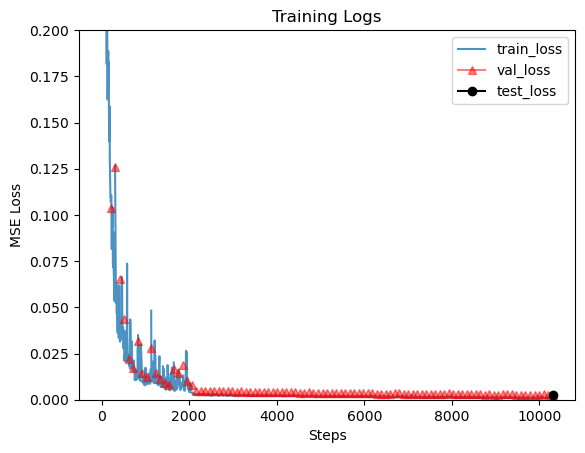

In [8]:
plot_losses(pd.read_csv(dataframe(0)), .2)

In [9]:
interact(plot_residuals, predict_input = fixed(predict_input(0)), predict_output = fixed(predict_output(0)), vessel = (0, len(predict_input(0)[0]) - 1))

interactive(children=(IntSlider(value=11, description='vessel', max=23), Output()), _dom_classes=('widget-inte…

<function __main__.plot_residuals(predict_input, predict_output, vessel)>

In [10]:
interact(plot_yhat, predict_input = fixed(predict_input(0)), predict_output = fixed(predict_output(0)), vessel = (0, len(predict_input(0)[0]) - 1))

interactive(children=(IntSlider(value=11, description='vessel', max=23), Output()), _dom_classes=('widget-inte…

<function __main__.plot_yhat(predict_input, predict_output, vessel)>

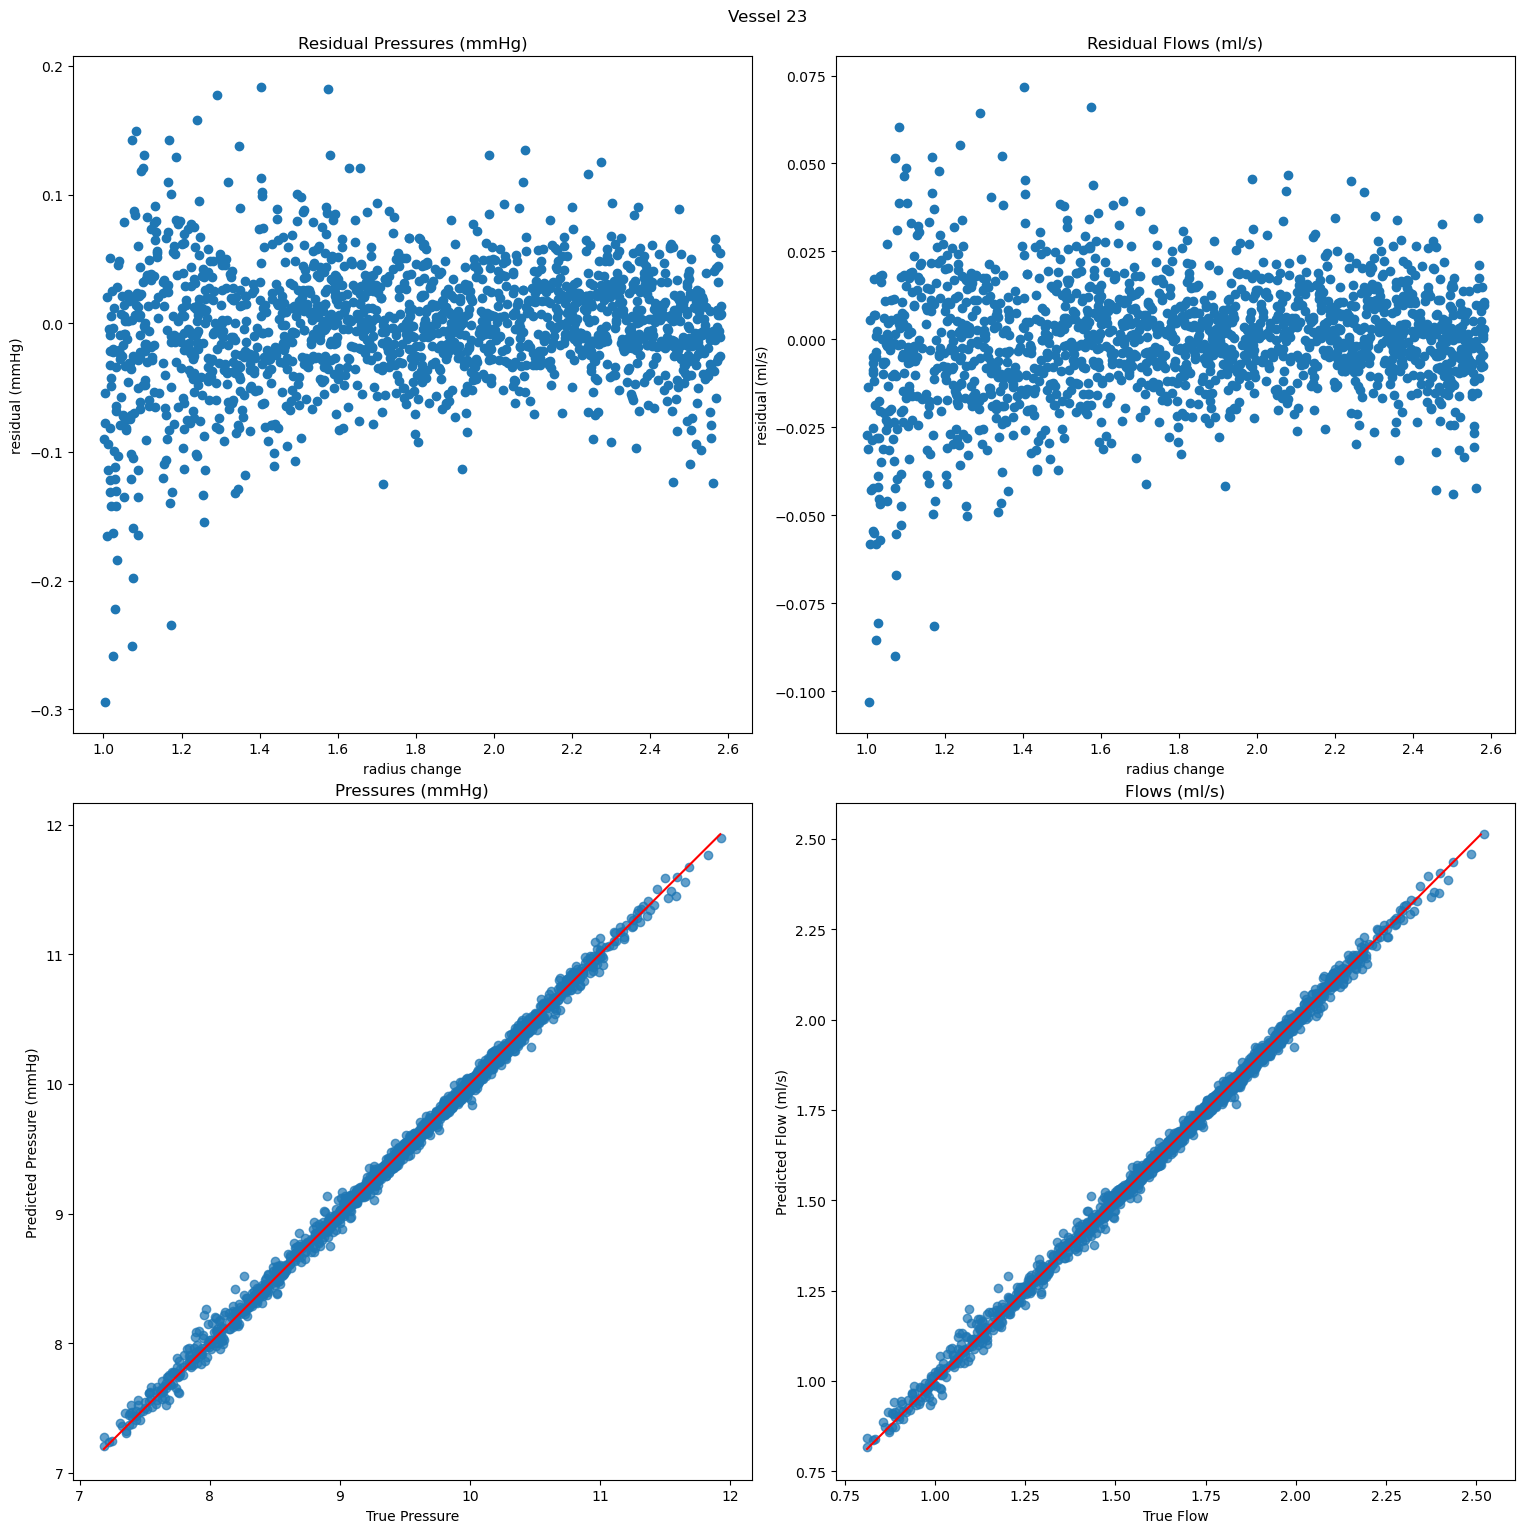

In [26]:
plot_animation(predict_input(0), predict_output(0), save = '../pptx/pptx_img/model.0.gif')

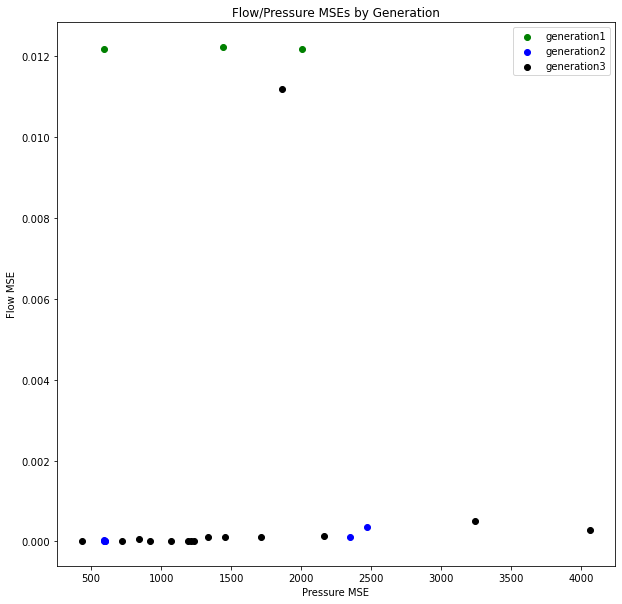

In [29]:
plot_by_generation(gen_map, changed_vessels, predict_output(0))

In [13]:
model_metrics(predict_input(0), predict_output(0))

5.3% | 5.09% | 3.92% | 3.91% | 3.93% | 3.94% | 3.91% | 4.42% | 5.09% | 3.05% | 4.78% | 4.31% | 4.98% | 5.11% | 5.2% | 4.34% | 5.23% | 4.75% | 4.94% | 5.08% | 5.56% | 5.46% | 5.06% | 5.09% | 
Average Pressure RAE: 4.68%
3.89% | 3.89% | 3.89% | 4.01% | 3.9% | 3.95% | 3.89% | 4.45% | 5.16% | 3.11% | 4.79% | 4.33% | 5.11% | 5.17% | 5.16% | 4.33% | 5.17% | 4.75% | 4.94% | 5.5% | 5.47% | 5.48% | 5.09% | 5.07% | 
Average Flow RAE: 4.6%
Average Total RAE: 4.64%
Max Relative Error: 11.983%
Avg Relative Error: 0.408%


# Version 1

Additional
- Normalization to (0, 1)
- Final Sigmoid layer

Reasoning:

The P/Q appeared to be normally distributed in EDA. Therefore, normalizing to 0 and 1 and using sigmoid (representing gaussian pdf) should work well. Furthermore, 0-1 is a better defined boundary than just std and mean.

Final Train Loss: 3.722718611243181e-05
Final Val Loss: 8.839136717142537e-05
Final Test Loss: 8.771974535193294e-05


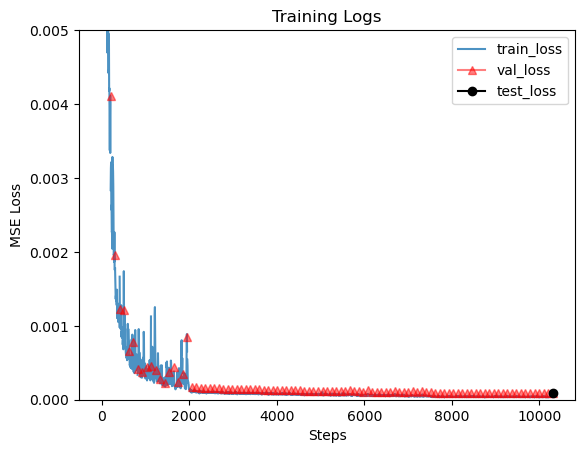

In [14]:

plot_losses(pd.read_csv(dataframe(1)), .005)

In [15]:
interact(plot_residuals, predict_input = fixed(predict_input(1)), predict_output = fixed(predict_output(1)), vessel = (0, len(predict_input(1)[0]) - 1))

interactive(children=(IntSlider(value=11, description='vessel', max=23), Output()), _dom_classes=('widget-inte…

<function __main__.plot_residuals(predict_input, predict_output, vessel)>

In [16]:
interact(plot_yhat, predict_input = fixed(predict_input(1)), predict_output = fixed(predict_output(1)), vessel = (0, len(predict_input(1)[0]) - 1))

interactive(children=(IntSlider(value=11, description='vessel', max=23), Output()), _dom_classes=('widget-inte…

<function __main__.plot_yhat(predict_input, predict_output, vessel)>

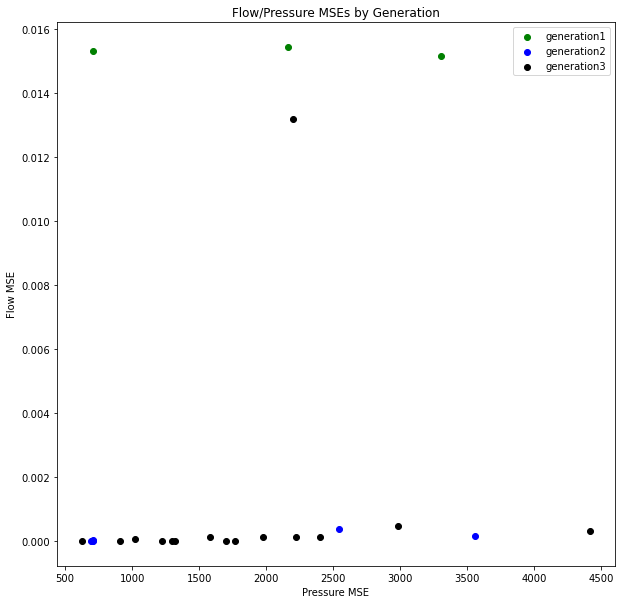

In [34]:
plot_by_generation(gen_map, changed_vessels, predict_output(1))

In [18]:
model_metrics(predict_input(1), predict_output(1))

6.63% | 6.12% | 4.23% | 4.25% | 4.2% | 4.18% | 4.23% | 4.47% | 6.24% | 3.24% | 5.76% | 4.08% | 5.93% | 5.91% | 5.42% | 4.88% | 5.55% | 4.97% | 5.51% | 5.64% | 6.62% | 6.51% | 5.5% | 5.42% | 
Average Pressure RAE: 5.23%
4.27% | 4.32% | 4.3% | 4.32% | 4.19% | 4.19% | 4.19% | 4.48% | 6.25% | 3.29% | 5.74% | 4.11% | 5.4% | 5.43% | 5.39% | 4.86% | 5.51% | 4.97% | 5.45% | 6.48% | 6.51% | 6.51% | 5.52% | 5.33% | 
Average Flow RAE: 5.04%
Average Total RAE: 5.14%
Max Relative Error: 13.408%
Avg Relative Error: 0.442%


Conclusions:
- The sigmoid + 0-1 Normalization causes more tail end inaccuracy due to sigmoid's nature. It

# Version 2

Addition:
- Huber Loss


Final Train Loss: 0.0004399881581775
Final Val Loss: 0.0011939879041165
Final Test Loss: 0.0011533224023878


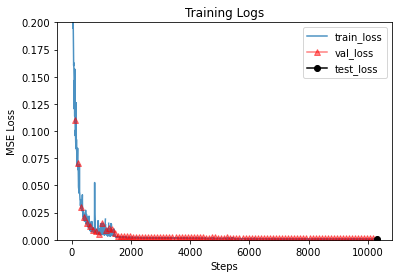

In [18]:

plot_losses(pd.read_csv(dataframe(2)), .2)

In [36]:
interact(plot_residuals, predict_input = fixed(predict_input(2)), predict_output = fixed(predict_output(2)), vessel = (0, len(predict_input(2)[0]) - 1))

interactive(children=(IntSlider(value=11, description='vessel', max=23), Output()), _dom_classes=('widget-inte…

<function __main__.plot_residuals(predict_input, predict_output, vessel)>

In [37]:
interact(plot_yhat, predict_input = fixed(predict_input(2)), predict_output = fixed(predict_output(2)), vessel = (0, len(predict_input(2)[0]) - 1))

interactive(children=(IntSlider(value=11, description='vessel', max=23), Output()), _dom_classes=('widget-inte…

<function __main__.plot_yhat(predict_input, predict_output, vessel)>

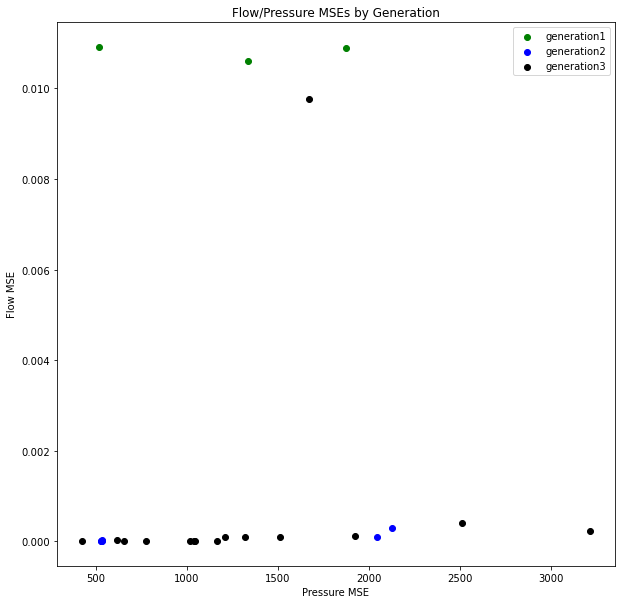

In [38]:
plot_by_generation(gen_map, changed_vessels, predict_output(2))

In [19]:
model_metrics(predict_input(1), predict_output(2))

5.33% | 4.99% | 3.72% | 3.81% | 3.77% | 3.76% | 3.76% | 4.11% | 4.78% | 2.95% | 4.94% | 3.83% | 5.0% | 4.88% | 4.75% | 4.19% | 4.78% | 4.53% | 4.97% | 4.6% | 5.24% | 5.35% | 4.36% | 4.6% | 
Average Pressure RAE: 4.46%
3.72% | 3.7% | 3.76% | 3.83% | 3.78% | 3.76% | 3.75% | 4.1% | 4.77% | 2.94% | 4.94% | 3.81% | 4.75% | 4.7% | 4.72% | 4.16% | 4.82% | 4.54% | 4.96% | 5.38% | 5.34% | 5.35% | 4.38% | 4.58% | 
Average Flow RAE: 4.36%
Average Total RAE: 4.41%
Max Relative Error: 9.833%
Avg Relative Error: 0.383%


# Version 4

Addition:
- Dropout  .5 every hidden layer, .2 in input layer
- Huber Loss

Final Train Loss: 0.0503746271133422
Final Val Loss: 0.0218878407031297
Final Test Loss: 0.0215094238519668


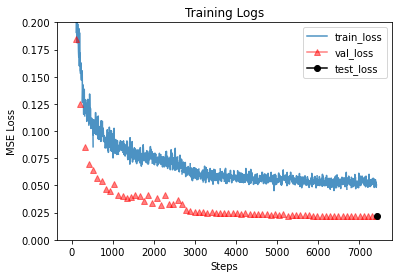

In [40]:
plot_losses(pd.read_csv(dataframe(3)), .2)

In [20]:
interact(plot_residuals, predict_input = fixed(predict_input(3)), predict_output = fixed(predict_output(3)), vessel = (0, len(predict_input(3)[0]) - 1))

interactive(children=(IntSlider(value=11, description='vessel', max=23), Output()), _dom_classes=('widget-inte…

<function __main__.plot_residuals(predict_input, predict_output, vessel)>

In [21]:
interact(plot_yhat, predict_input = fixed(predict_input(3)), predict_output = fixed(predict_output(3)), vessel = (0, len(predict_input(3)[0]) - 1))

interactive(children=(IntSlider(value=11, description='vessel', max=23), Output()), _dom_classes=('widget-inte…

<function __main__.plot_yhat(predict_input, predict_output, vessel)>

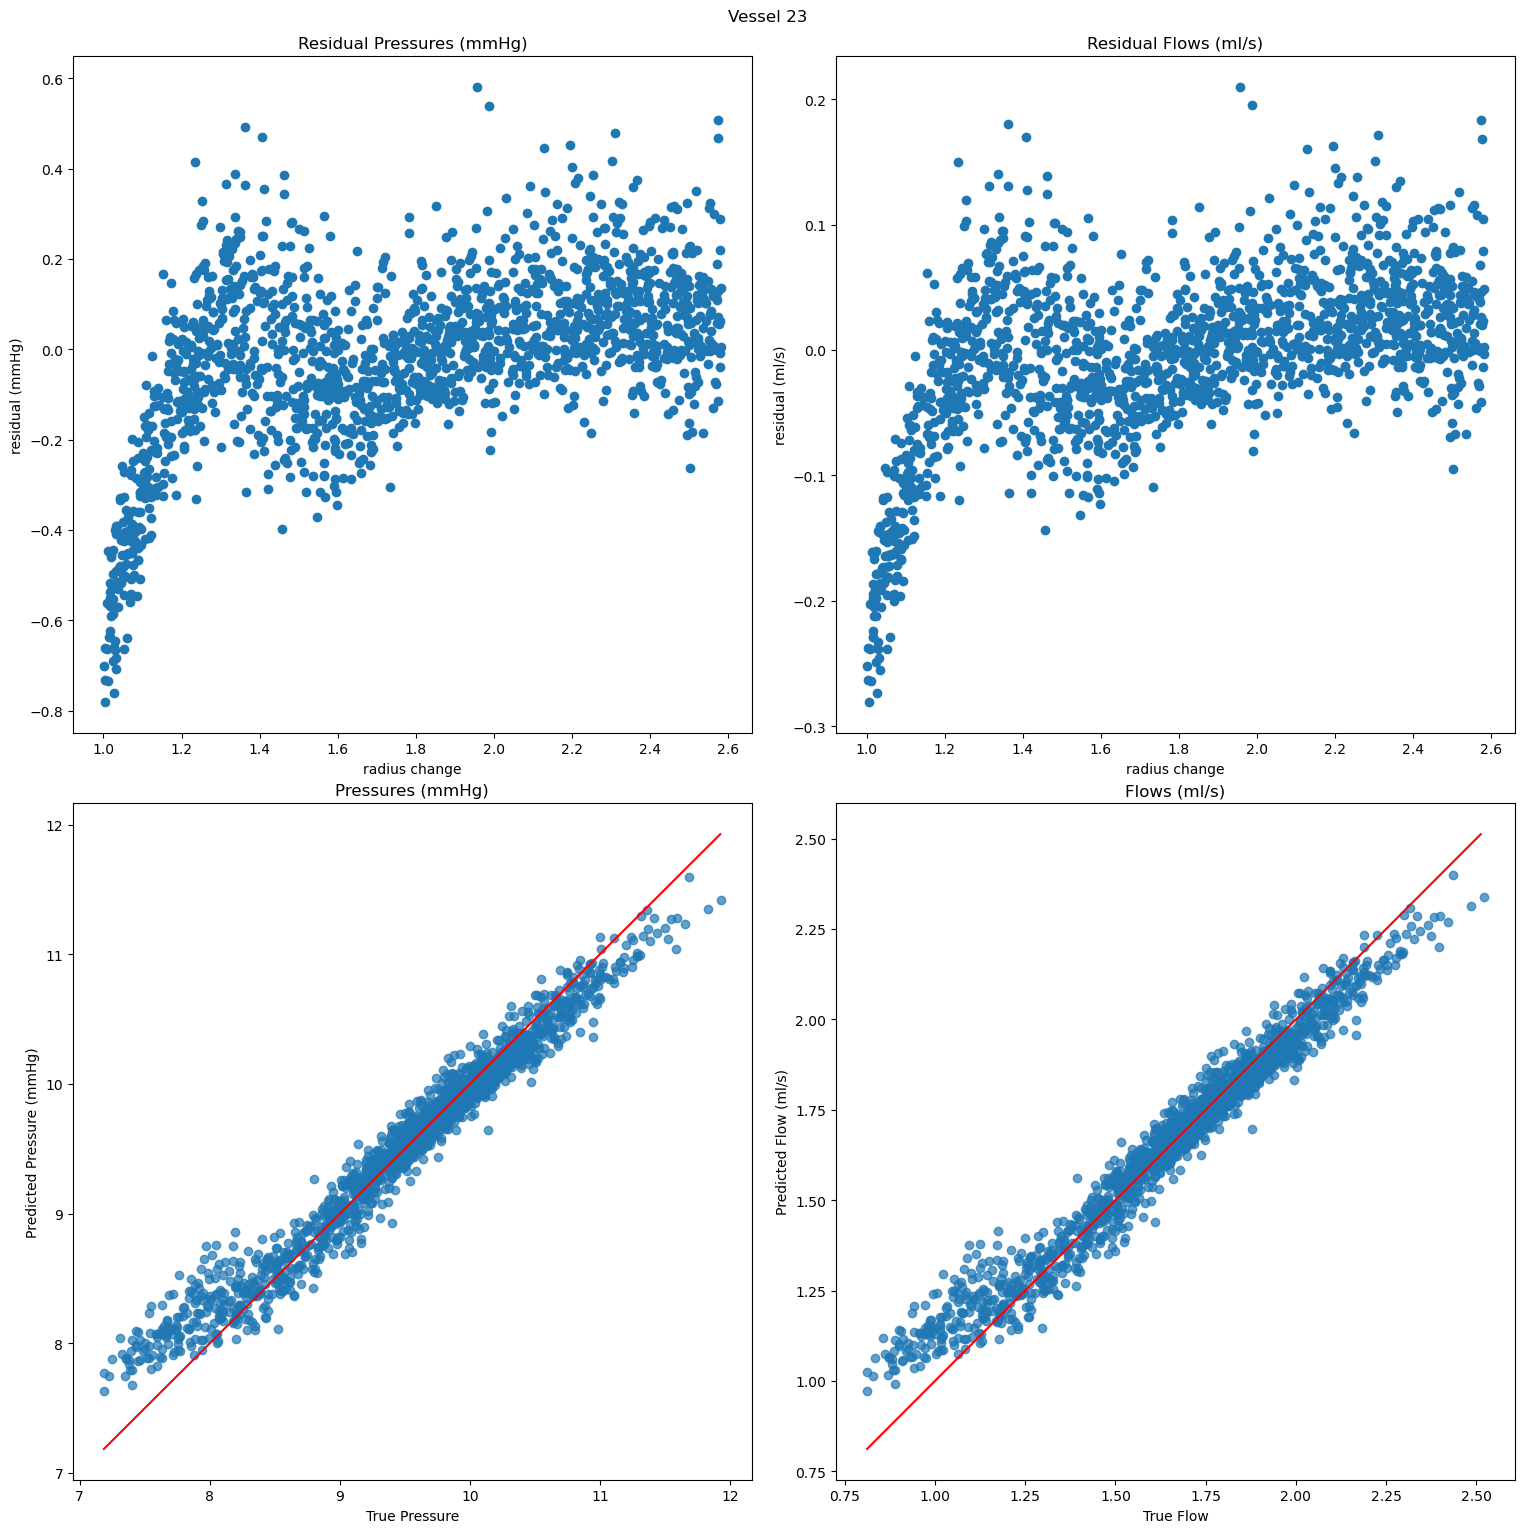

In [27]:
plot_animation(predict_input(3), predict_output(3), save = '../pptx/pptx_img/model.dropout.gif')

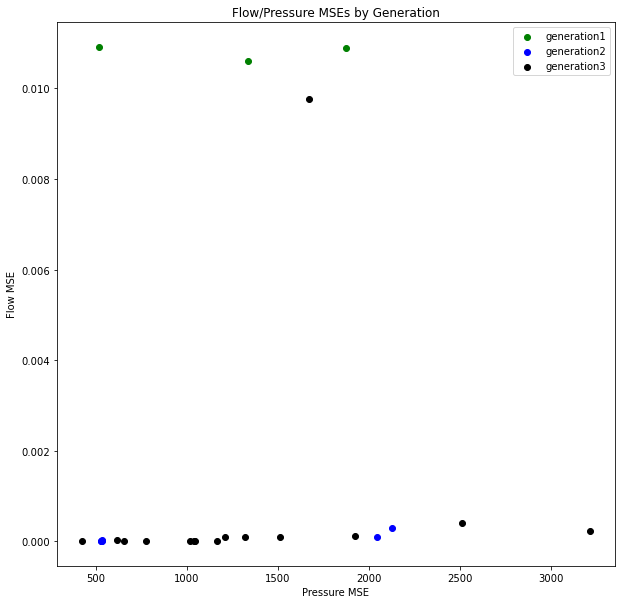

In [43]:
plot_by_generation(gen_map, changed_vessels, predict_output(2))

In [22]:
model_metrics(predict_input(2), predict_output(3))

25.23% | 23.66% | 13.45% | 13.41% | 13.44% | 13.44% | 13.44% | 19.56% | 20.47% | 15.89% | 20.09% | 17.38% | 24.45% | 24.04% | 20.9% | 21.7% | 20.88% | 21.92% | 19.22% | 24.16% | 27.97% | 22.89% | 20.31% | 19.83% | 
Average Pressure RAE: 19.91%
13.45% | 13.45% | 13.44% | 14.81% | 13.45% | 13.44% | 13.43% | 19.55% | 20.49% | 15.99% | 20.06% | 17.4% | 20.91% | 20.91% | 20.91% | 21.66% | 20.87% | 21.91% | 19.24% | 22.88% | 22.92% | 22.89% | 20.34% | 19.82% | 
Average Flow RAE: 18.51%
Average Total RAE: 19.21%
Max Relative Error: 53.465%
Avg Relative Error: 1.713%


Versions 4 & 5 are repeated but with lower dropout rates.

In [45]:
interact(plot_yhat, predict_input = fixed(predict_input(3)), predict_output = fixed(predict_output(3)), vessel = (0, len(predict_input(3)[0]) - 1))

interactive(children=(IntSlider(value=11, description='vessel', max=23), Output()), _dom_classes=('widget-inte…

<function __main__.plot_yhat(predict_input, predict_output, vessel)>

In [46]:
model_metrics(predict_output(4)) # p = .2, no input dropout

11.15% | 11.09% | 6.37% | 6.39% | 6.36% | 6.37% | 6.37% | 8.63% | 9.49% | 7.24% | 9.36% | 7.99% | 10.5% | 10.63% | 9.39% | 8.47% | 9.27% | 9.58% | 8.73% | 9.6% | 10.66% | 9.68% | 8.73% | 9.69% | 
Average Pressure RAE: 8.82%
6.35% | 6.37% | 6.35% | 6.74% | 6.37% | 6.36% | 6.37% | 8.64% | 9.49% | 7.25% | 9.35% | 7.99% | 9.37% | 9.37% | 9.41% | 8.47% | 9.27% | 9.59% | 8.73% | 9.69% | 9.68% | 9.68% | 8.74% | 9.7% | 
Average Flow RAE: 8.3%
Average Total RAE: 8.56%


In [47]:
model_metrics(predict_output(5)) # p = .1 no input dropout

9.49% | 8.67% | 5.65% | 5.68% | 5.65% | 5.65% | 5.64% | 7.67% | 8.25% | 5.7% | 7.62% | 6.74% | 8.35% | 8.65% | 8.4% | 6.8% | 7.83% | 7.95% | 7.53% | 7.56% | 8.33% | 8.23% | 7.48% | 7.55% | 
Average Pressure RAE: 7.38%
5.73% | 5.72% | 5.73% | 5.82% | 5.65% | 5.66% | 5.66% | 7.66% | 8.26% | 5.75% | 7.63% | 6.75% | 8.38% | 8.37% | 8.38% | 6.79% | 7.85% | 7.95% | 7.55% | 8.26% | 8.25% | 8.25% | 7.48% | 7.56% | 
Average Flow RAE: 7.13%
Average Total RAE: 7.25%


Worse: Dropout regularization does not seem to work. Furthermore, I anticipate that overfitting is not necessarily bad, since we may need those same numbers anyways when predicting (although our current predict set does not contain any repeat values from training)

# Version 6

Additions:
- L2 Norm  weight-decay = .01

In [28]:
interact(plot_yhat, predict_input = fixed(predict_input(6)), predict_output = fixed(predict_output(6)), vessel = (0, len(predict_input(6)[0]) - 1))

interactive(children=(IntSlider(value=11, description='vessel', max=23), Output()), _dom_classes=('widget-inte…

<function __main__.plot_yhat(predict_input, predict_output, vessel)>

In [29]:
model_metrics(predict_output(6)) # p = .2, no input dropout

TypeError: model_metrics() missing 1 required positional argument: 'predict_output'

Version 7, weight-decay = .001

In [31]:
model_metrics(predict_input(7), predict_output(7)) # p = .2, no input dropout

16.8% | 16.05% | 11.45% | 11.46% | 11.46% | 11.45% | 11.45% | 11.25% | 17.79% | 11.54% | 52.1% | 10.78% | 34.45% | 38.85% | 14.39% | 19.88% | 57.08% | 14.46% | 50.14% | 29.64% | 28.91% | 21.05% | 38.05% | 16.66% | 
Average Pressure RAE: 23.21%
8.85% | 8.85% | 8.85% | 13.12% | 11.45% | 11.44% | 11.45% | 11.27% | 17.79% | 11.43% | 52.11% | 10.78% | 14.39% | 14.39% | 14.39% | 19.88% | 57.09% | 14.47% | 50.14% | 21.06% | 21.05% | 21.06% | 38.07% | 16.66% | 
Average Flow RAE: 20.0%
Average Total RAE: 21.61%
Max Relative Error: 45.419%
Avg Relative Error: 1.72%


Version 8
- weight-decay = 1e-4
Version 9
- weight-decay = 1e-4
- Epochs = 200

Final Train Loss: 0.00069362425711
Final Val Loss: 0.0010961422231048
Final Test Loss: 0.0010502403602004


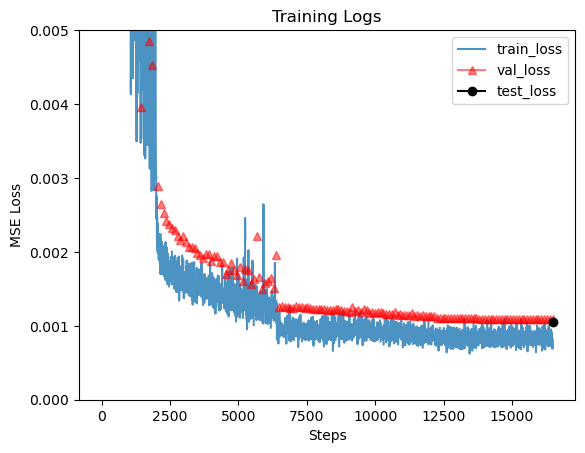

In [32]:
plot_losses(pd.read_csv(dataframe(9)), .005)

In [33]:
interact(plot_residuals, predict_input = fixed(predict_input(9)), predict_output = fixed(predict_output(9)), vessel = (0, len(predict_input(9)[0]) - 1))

interactive(children=(IntSlider(value=11, description='vessel', max=23), Output()), _dom_classes=('widget-inte…

<function __main__.plot_residuals(predict_input, predict_output, vessel)>

In [34]:
interact(plot_yhat, predict_input = fixed(predict_input(9)), predict_output = fixed(predict_output(9)), vessel = (0, len(predict_input(9)[0]) - 1))

interactive(children=(IntSlider(value=11, description='vessel', max=23), Output()), _dom_classes=('widget-inte…

<function __main__.plot_yhat(predict_input, predict_output, vessel)>

In [36]:
model_metrics(predict_input(9), predict_output(9))

4.92% | 4.87% | 2.89% | 2.94% | 2.9% | 2.9% | 2.91% | 3.01% | 4.16% | 2.39% | 4.07% | 2.98% | 5.13% | 4.59% | 4.22% | 4.19% | 4.2% | 3.63% | 4.22% | 4.81% | 5.54% | 5.43% | 4.12% | 4.02% | 
Average Pressure RAE: 3.96%
2.91% | 2.9% | 2.9% | 3.25% | 2.9% | 2.9% | 2.91% | 3.02% | 4.17% | 2.37% | 4.09% | 2.99% | 4.23% | 4.25% | 4.23% | 4.2% | 4.18% | 3.64% | 4.24% | 5.43% | 5.43% | 5.42% | 4.1% | 4.02% | 
Average Flow RAE: 3.78%
Average Total RAE: 3.87%
Max Relative Error: 10.862%
Avg Relative Error: 0.332%


Version 16
- L2 = 5e-5

Final Train Loss: 0.0004776641726493
Final Val Loss: 0.0007344202604144
Final Test Loss: 0.0006697816425003


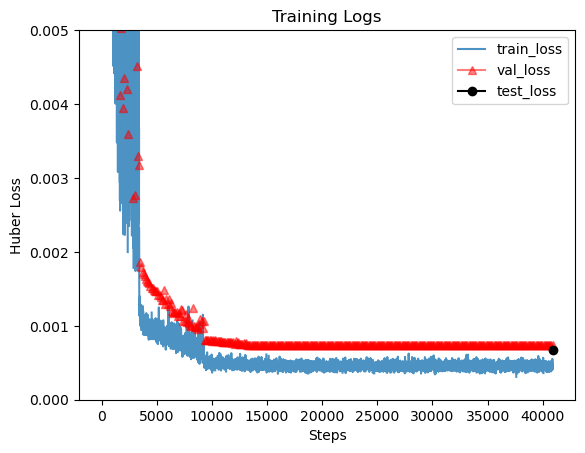

In [42]:
plot_losses(pd.read_csv(dataframe(16)), .005)

In [38]:
interact(plot_residuals, predict_input = fixed(predict_input(16)), predict_output = fixed(predict_output(16)), vessel = (0, len(predict_input(16)[0]) - 1))

interactive(children=(IntSlider(value=11, description='vessel', max=23), Output()), _dom_classes=('widget-inte…

<function __main__.plot_residuals(predict_input, predict_output, vessel)>

In [39]:
interact(plot_yhat, predict_input = fixed(predict_input(16)), predict_output = fixed(predict_output(16)), vessel = (0, len(predict_input(16)[0])-1))

interactive(children=(IntSlider(value=11, description='vessel', max=23), Output()), _dom_classes=('widget-inte…

<function __main__.plot_yhat(predict_input, predict_output, vessel)>

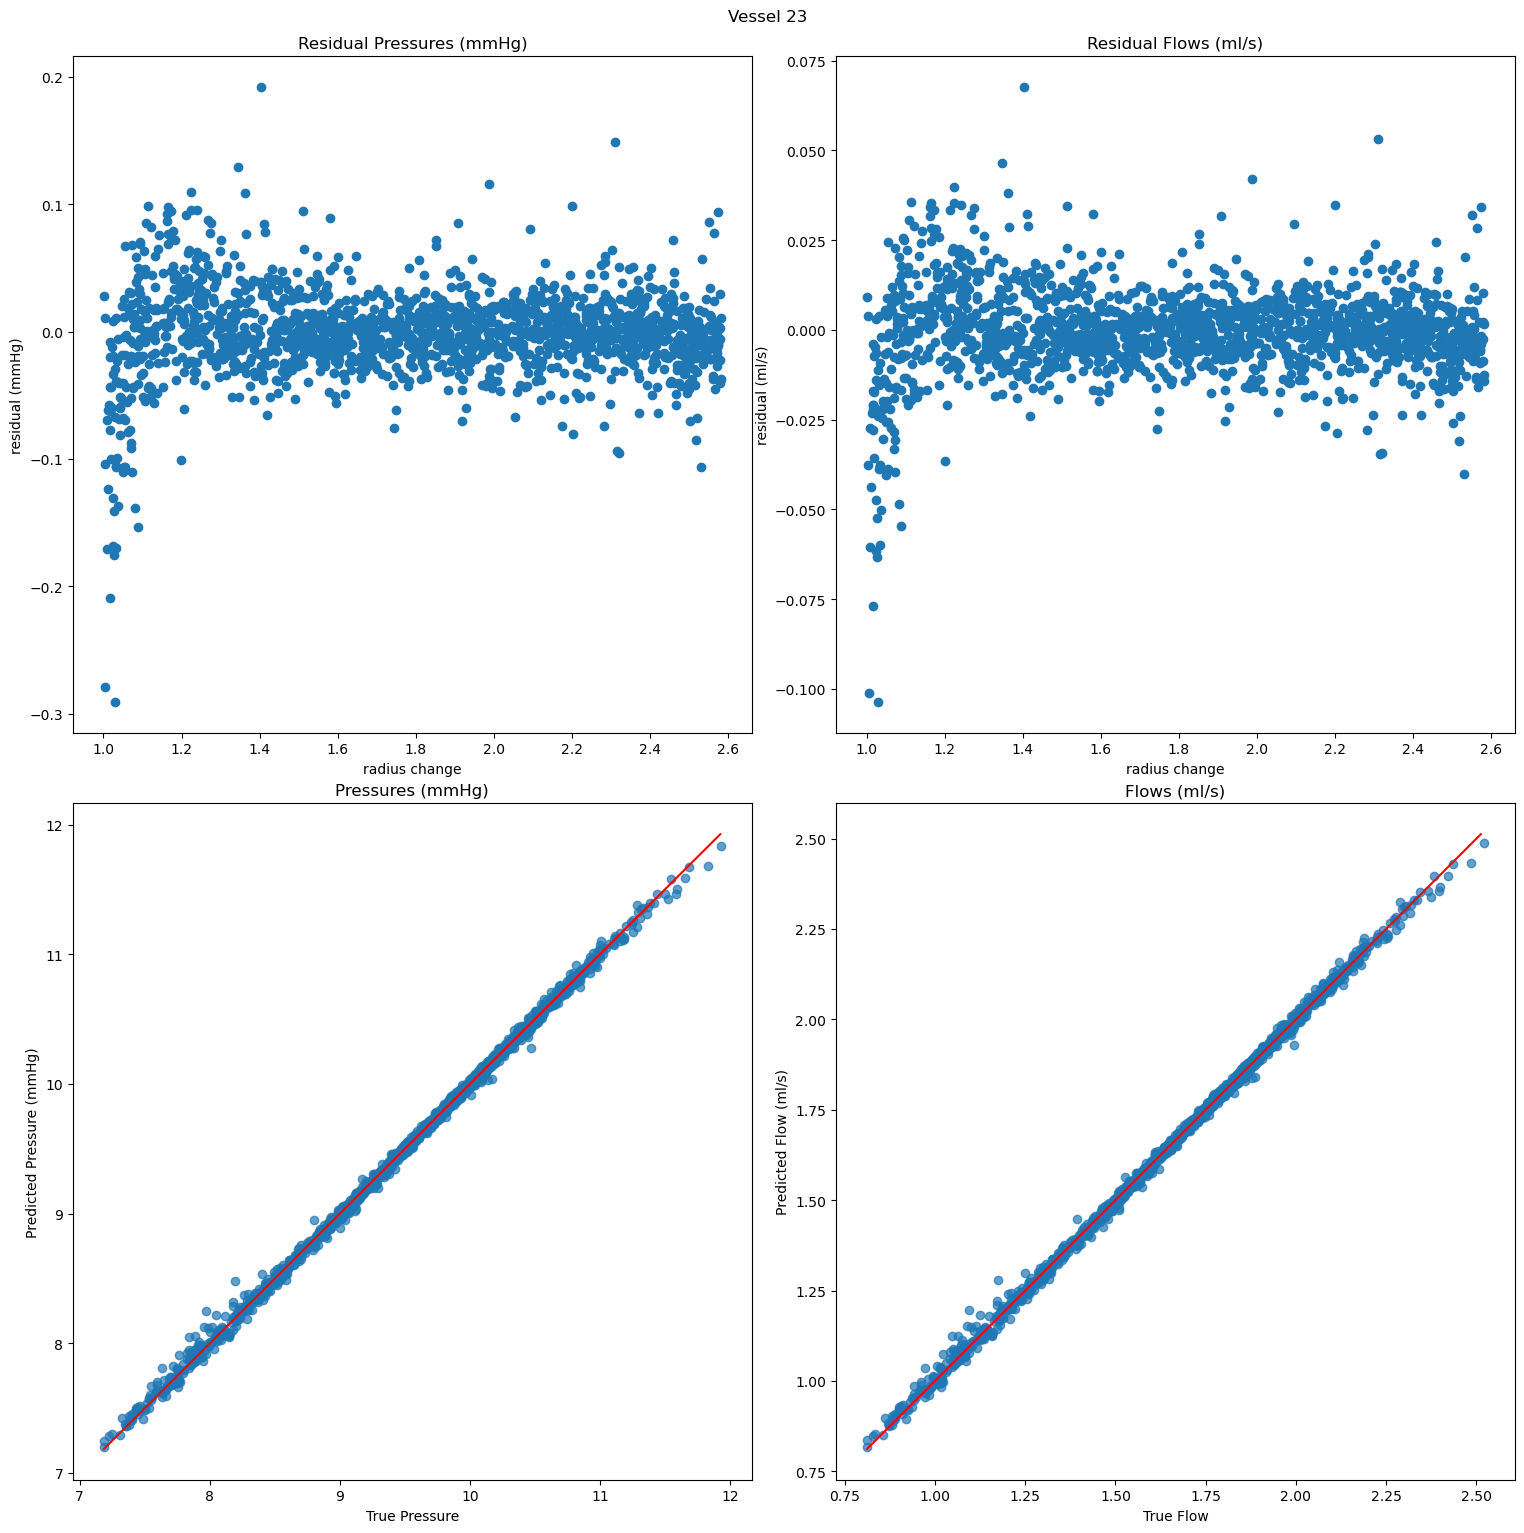

In [43]:
plot_animation(predict_input(16), predict_output(16), save ='../pptx/pptx_img/model.l2.gif')

In [40]:
model_metrics(predict_input(16), predict_output(16))

4.15% | 3.85% | 2.55% | 2.64% | 2.54% | 2.55% | 2.53% | 2.72% | 3.67% | 2.21% | 3.38% | 2.49% | 3.82% | 3.77% | 3.43% | 3.25% | 3.48% | 3.05% | 3.38% | 3.77% | 3.99% | 3.95% | 3.33% | 3.38% | 
Average Pressure RAE: 3.25%
2.51% | 2.5% | 2.51% | 2.75% | 2.55% | 2.54% | 2.54% | 2.73% | 3.66% | 2.22% | 3.38% | 2.49% | 3.45% | 3.44% | 3.47% | 3.25% | 3.47% | 3.04% | 3.39% | 3.96% | 3.96% | 3.94% | 3.32% | 3.4% | 
Average Flow RAE: 3.1%
Average Total RAE: 3.17%
Max Relative Error: 10.905%
Avg Relative Error: 0.275%


Worked. Definitely exhasperated the effect of 1-1.4 exponential change though (potentially fix w/ data.) Also, with version 16, training is extended to nearly 400 epochs, > 2x the number of previous. Also, this value may not be robust for different models.

# Version 10

Architecture changes:
- 2 layer - 1500

In [59]:
model_metrics(predict_output(10))

5.11% | 4.54% | 3.18% | 3.25% | 3.19% | 3.19% | 3.18% | 3.33% | 4.43% | 2.66% | 4.48% | 3.17% | 4.67% | 4.83% | 4.64% | 4.29% | 4.66% | 3.89% | 4.25% | 4.41% | 4.99% | 5.44% | 4.51% | 4.12% | 
Average Pressure RAE: 4.1%
3.13% | 3.14% | 3.13% | 3.49% | 3.19% | 3.19% | 3.19% | 3.32% | 4.42% | 2.64% | 4.48% | 3.17% | 4.65% | 4.65% | 4.65% | 4.29% | 4.65% | 3.87% | 4.24% | 5.43% | 5.44% | 5.44% | 4.51% | 4.12% | 
Average Flow RAE: 4.02%
Average Total RAE: 4.06%


Fail: Despite having more information storage (~1.5x parameters), it performs slightly worse

Version 11
- 5 x 800
Version 12
- 5 x 1000

In [60]:
model_metrics(predict_output(11))

5.36% | 5.58% | 4.96% | 4.94% | 4.96% | 4.96% | 4.95% | 3.49% | 4.5% | 2.97% | 4.6% | 3.23% | 5.47% | 5.2% | 4.46% | 15.32% | 4.72% | 4.5% | 4.47% | 26.86% | 25.32% | 7.95% | 4.83% | 4.36% | 
Average Pressure RAE: 7.0%
3.79% | 3.8% | 3.79% | 6.07% | 4.96% | 4.96% | 4.96% | 3.5% | 4.51% | 2.87% | 4.6% | 3.23% | 4.46% | 4.46% | 4.46% | 15.32% | 4.73% | 4.51% | 4.46% | 7.94% | 7.94% | 7.95% | 4.83% | 4.36% | 
Average Flow RAE: 5.27%
Average Total RAE: 6.13%


In [61]:
model_metrics(predict_output(12))

4.68% | 4.37% | 4.13% | 4.13% | 4.13% | 4.13% | 4.13% | 2.73% | 3.79% | 2.43% | 4.46% | 2.34% | 4.63% | 5.07% | 3.92% | 15.14% | 4.16% | 3.86% | 3.77% | 15.18% | 16.62% | 5.29% | 3.84% | 3.52% | 
Average Pressure RAE: 5.44%
3.02% | 3.03% | 3.02% | 5.41% | 4.13% | 4.13% | 4.13% | 2.73% | 3.8% | 2.37% | 4.47% | 2.34% | 3.92% | 3.92% | 3.92% | 15.13% | 4.16% | 3.86% | 3.77% | 5.29% | 5.29% | 5.29% | 3.84% | 3.52% | 
Average Flow RAE: 4.35%
Average Total RAE: 4.89%


Version 13
- 10 x 700
- L2, 1e-7

In [62]:
model_metrics(predict_output(13))

67.71% | 66.06% | 14.64% | 14.66% | 14.67% | 14.65% | 14.64% | 92.65% | 65.71% | 27.89% | 54.08% | 54.6% | 67.1% | 57.37% | 18.89% | 21.72% | 59.89% | 83.42% | 51.86% | 32.48% | 45.28% | 53.02% | 39.44% | 81.56% | 
Average Pressure RAE: 46.42%
15.11% | 15.11% | 15.13% | 15.9% | 14.64% | 14.65% | 14.63% | 92.68% | 65.77% | 27.83% | 54.14% | 54.6% | 18.9% | 18.89% | 18.89% | 21.73% | 59.91% | 83.39% | 51.84% | 53.01% | 53.02% | 53.03% | 39.45% | 81.57% | 
Average Flow RAE: 39.74%
Average Total RAE: 43.08%


Fail: same # of parameters, worse. Deeper networks may not be more optimal.

Version 14
- 3 x 2000
Version 15
- 3 x 500
- 

In [63]:
model_metrics(predict_output(14))

5.04% | 4.34% | 3.12% | 3.18% | 3.13% | 3.12% | 3.12% | 3.02% | 4.44% | 2.53% | 4.34% | 3.04% | 4.76% | 4.45% | 4.16% | 4.33% | 4.21% | 3.62% | 3.97% | 5.0% | 5.51% | 5.62% | 4.11% | 4.0% | 
Average Pressure RAE: 4.01%
3.11% | 3.1% | 3.11% | 3.44% | 3.13% | 3.12% | 3.13% | 3.02% | 4.44% | 2.54% | 4.35% | 3.05% | 4.15% | 4.15% | 4.15% | 4.33% | 4.2% | 3.62% | 3.97% | 5.63% | 5.62% | 5.63% | 4.11% | 4.0% | 
Average Flow RAE: 3.88%
Average Total RAE: 3.94%


In [64]:
model_metrics(predict_output(15))

5.18% | 4.67% | 2.83% | 2.9% | 2.83% | 2.82% | 2.83% | 2.89% | 4.21% | 2.48% | 4.32% | 2.88% | 4.93% | 5.07% | 4.22% | 4.72% | 4.28% | 4.07% | 4.39% | 5.96% | 6.32% | 5.74% | 4.06% | 4.2% | 
Average Pressure RAE: 4.12%
2.77% | 2.77% | 2.77% | 3.34% | 2.83% | 2.82% | 2.83% | 2.89% | 4.21% | 2.43% | 4.33% | 2.88% | 4.22% | 4.22% | 4.22% | 4.74% | 4.27% | 4.07% | 4.4% | 5.76% | 5.76% | 5.76% | 4.06% | 4.2% | 
Average Flow RAE: 3.86%
Average Total RAE: 3.99%


# Version 17

Testing how crucial data is.
4096 sample size

Final Train Loss: 0.0009106581564992
Final Val Loss: 0.0034136571921408
Final Test Loss: 0.0038491790182888


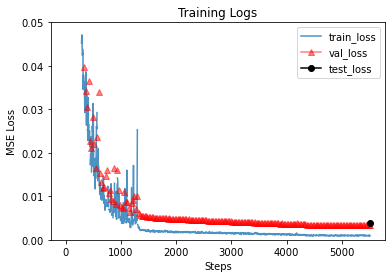

In [65]:
plot_losses(pd.read_csv(dataframe(17)), .05)

In [66]:
interact(plot_residuals, predict_input = fixed(predict_input(17)), predict_output = fixed(predict_output(17)), vessel = (0, len(predict_input(17)[0]) - 1))

interactive(children=(IntSlider(value=11, description='vessel', max=23), Output()), _dom_classes=('widget-inte…

<function __main__.plot_residuals(predict_input, predict_output, vessel)>

In [67]:
interact(plot_yhat, predict_input = fixed(predict_input(17)), predict_output = fixed(predict_output(17)), vessel = (0, len(predict_input(17)[0])-1))

interactive(children=(IntSlider(value=11, description='vessel', max=23), Output()), _dom_classes=('widget-inte…

<function __main__.plot_yhat(predict_input, predict_output, vessel)>

In [68]:
model_metrics(predict_output(17))

8.99% | 9.72% | 6.55% | 6.56% | 6.58% | 6.64% | 6.62% | 6.7% | 9.34% | 4.45% | 9.06% | 5.52% | 8.61% | 9.13% | 9.18% | 9.46% | 8.19% | 7.63% | 8.41% | 8.6% | 9.26% | 10.2% | 8.39% | 8.38% | 
Average Pressure RAE: 8.01%
6.69% | 6.77% | 6.69% | 7.2% | 6.64% | 6.57% | 6.6% | 6.64% | 9.29% | 4.44% | 8.99% | 5.52% | 9.22% | 9.17% | 9.15% | 9.46% | 8.12% | 7.6% | 8.26% | 10.25% | 10.3% | 10.22% | 8.46% | 8.4% | 
Average Flow RAE: 7.94%
Average Total RAE: 7.98%


# Version 18

Test for predicting only the first 3 (which are batched and in same generation)
- Gain an intuition for what happens when predicting for 1 branch

In [69]:
model_metrics(predict_output(18))

3.42% | 3.25% | 3.33% | 
Average Pressure RAE: 3.34%
2.86% | 2.86% | 2.87% | 
Average Flow RAE: 2.86%
Average Total RAE: 3.1%


Version 21
- intuition on predicting gen 1 using only 3 inputs

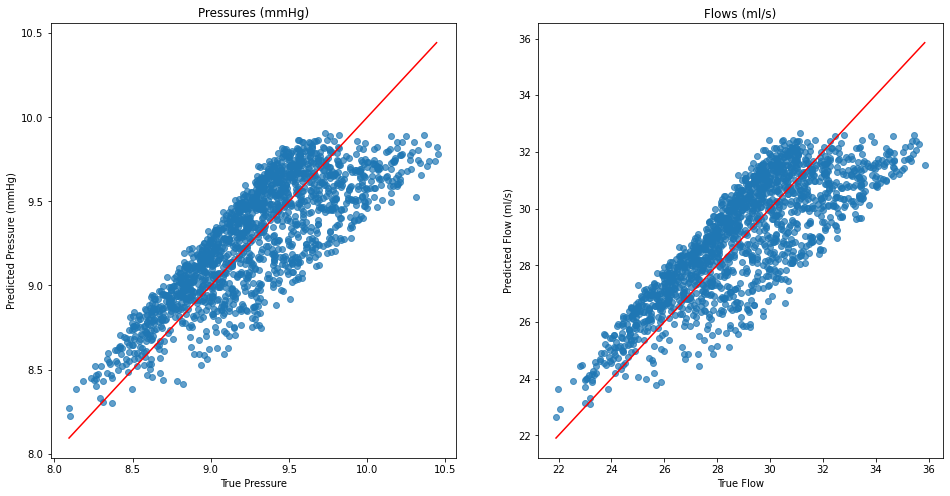

In [70]:
plot_yhat(predict_input = predict_input(21), predict_output = predict_output(21), vessel = 2)

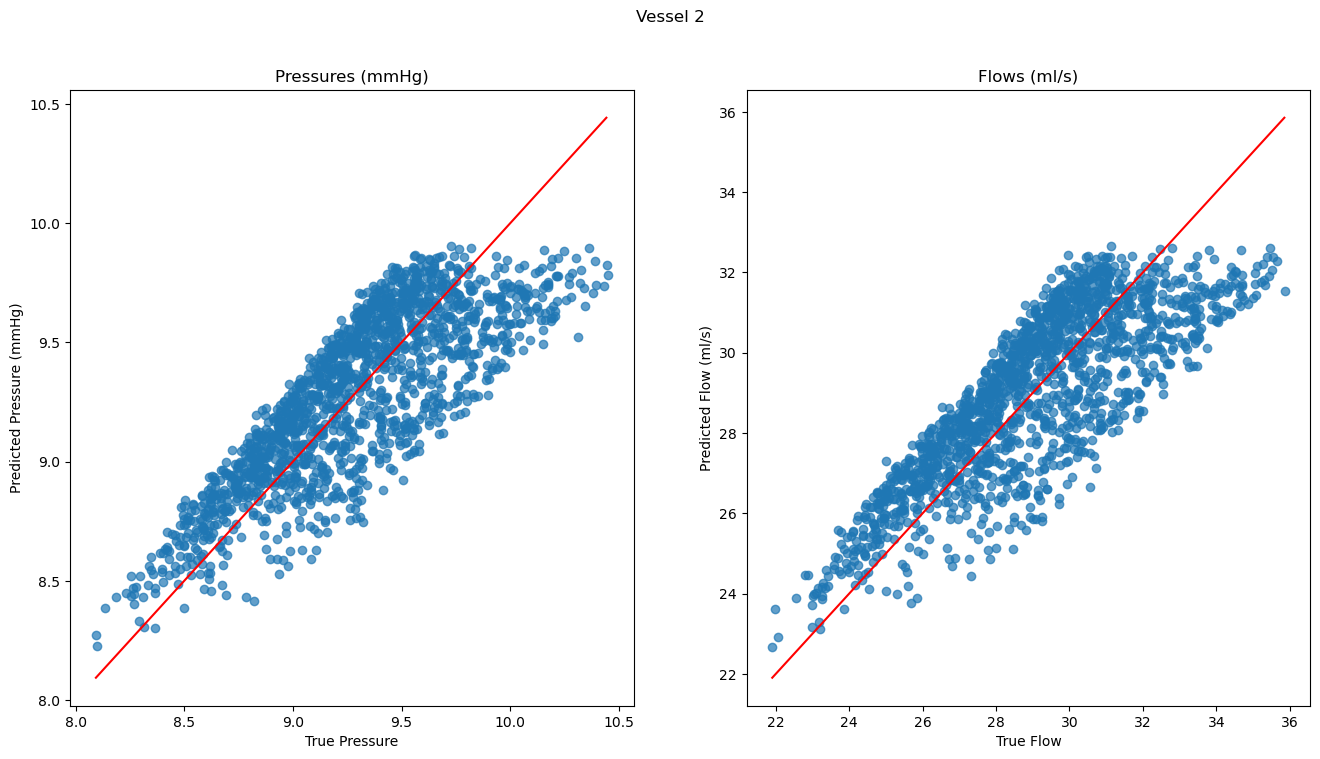

In [44]:
plot_yhat_animation(predict_input(21), predict_output(21), save = '../pptx/pptx_img/model.linear.gif')

In [71]:
model_metrics(predict_output(21))

63.23% | 59.7% | 60.49% | 
Average Pressure RAE: 61.14%
61.01% | 61.06% | 61.03% | 
Average Flow RAE: 61.03%
Average Total RAE: 61.09%


Version 19
- intuition on predicting for gen 2

Final Train Loss: 0.0003907718346454
Final Val Loss: 0.0012714869808405
Final Test Loss: 0.0011459956876933


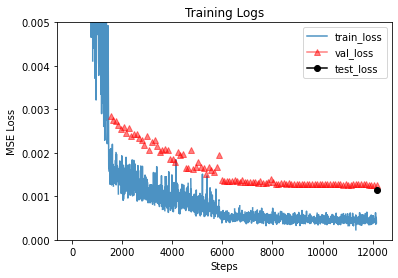

In [72]:
plot_losses(pd.read_csv(dataframe(19)), .005)

In [73]:
model_metrics(predict_output(19))

4.3% | 
Average Pressure RAE: 4.3%
4.4% | 
Average Flow RAE: 4.4%
Average Total RAE: 4.35%


Version 20
- intuition of inputs without initial 3 inputs.

IndexError: index 2 is out of bounds for dimension 1 with size 2

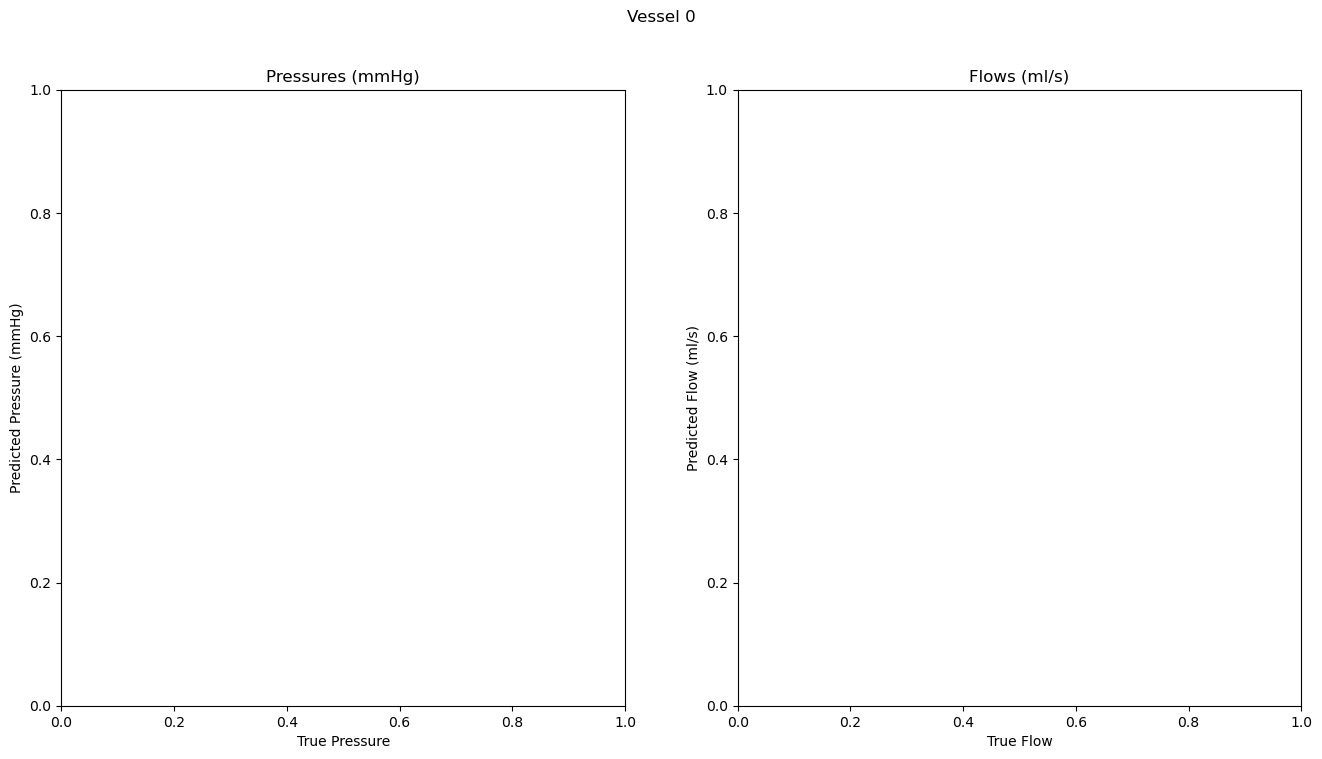

In [45]:
plot_yhat_animation(predict_input(20), predict_output(20), save = '../pptx/pptx_img/model.wogen1.gif')

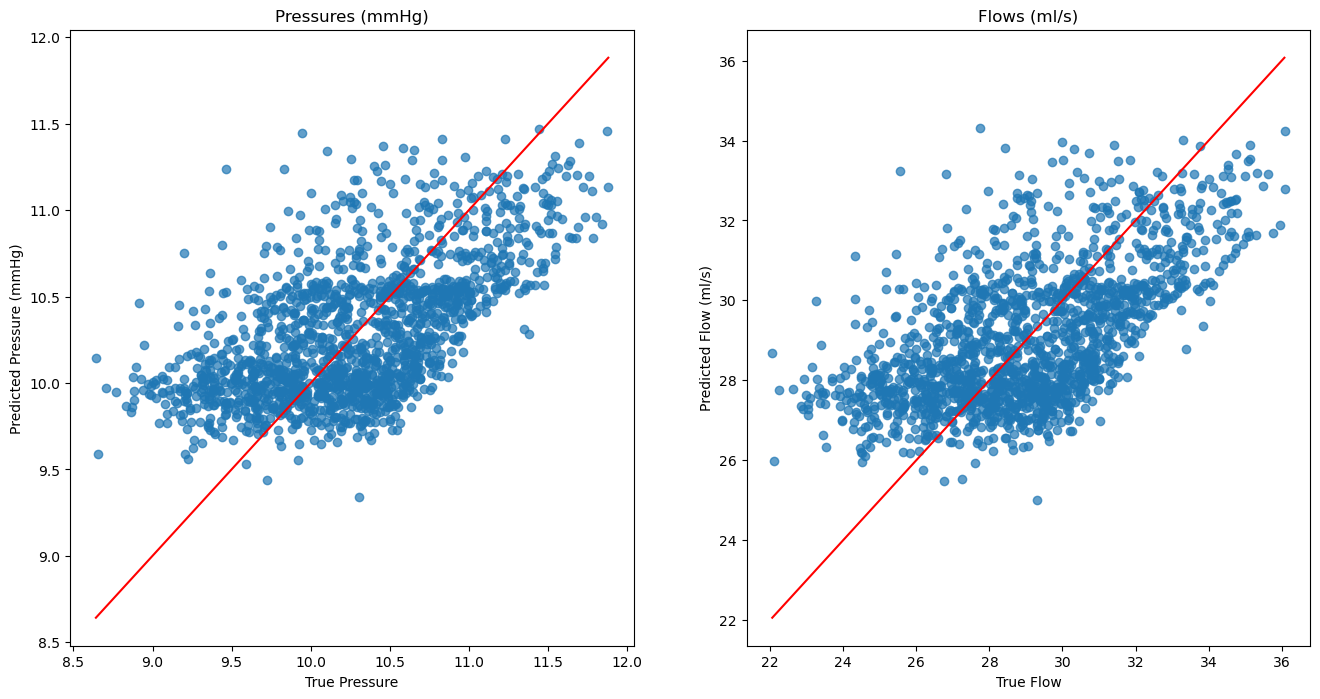

In [47]:
plot_yhat(predict_input = predict_input(20), predict_output = predict_output(20), vessel = 0)

In [75]:
model_metrics(predict_output(20))

84.11% | 
Average Pressure RAE: 84.11%
83.41% | 
Average Flow RAE: 83.41%
Average Total RAE: 83.76%


# Version 22 

Using P and Q from Gen 1 to predict a single value of gen 2

Final Train Loss: 0.0002765792305581
Final Val Loss: 0.000546142051462
Final Test Loss: 0.0005692857084795


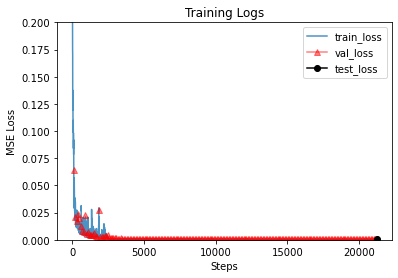

In [76]:
plot_losses(pd.read_csv(dataframe(22)))

In [77]:
model_metrics(predict_output(22))

3.34% | 3.13% | 2.98% | 3.07% | 
Average Pressure RAE: 3.13%
2.8% | 2.79% | 2.79% | 3.3% | 
Average Flow RAE: 2.92%
Average Total RAE: 3.03%


# Version 23

Partially utilizing generational structure
    - Gen 1 P/Q -> Gen2 P/Q -> Gen3 P/Q


Final Train Loss: 0.0006221429794095
Final Val Loss: 0.000988662824966
Final Test Loss: 0.0009298356599174


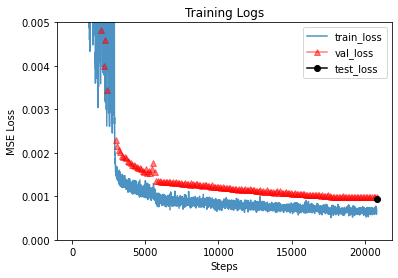

In [78]:
plot_losses(pd.read_csv(dataframe(23),),  0.005)

In [79]:
interact(plot_residuals, predict_input = fixed(predict_input(23)), predict_output = fixed(predict_output(23)), vessel = (0, len(predict_input(23)[0]) - 1))

interactive(children=(IntSlider(value=11, description='vessel', max=23), Output()), _dom_classes=('widget-inte…

<function __main__.plot_residuals(predict_input, predict_output, vessel)>

In [80]:
interact(plot_yhat, predict_input = fixed(predict_input(23)), predict_output = fixed(predict_output(23)), vessel = (0, len(predict_input(23)[0]) - 1))

interactive(children=(IntSlider(value=11, description='vessel', max=23), Output()), _dom_classes=('widget-inte…

<function __main__.plot_yhat(predict_input, predict_output, vessel)>

In [81]:
model_metrics(predict_output(23))

5.42% | 4.93% | 4.96% | 3.37% | 3.32% | 3.32% | 3.33% | 2.59% | 4.22% | 2.58% | 3.6% | 2.47% | 3.64% | 3.56% | 3.31% | 3.65% | 3.68% | 2.93% | 3.64% | 3.73% | 4.29% | 4.32% | 3.81% | 3.7% | 
Average Pressure RAE: 3.68%
4.27% | 4.61% | 4.31% | 7.94% | 3.33% | 3.32% | 3.32% | 2.6% | 4.23% | 2.59% | 3.6% | 2.48% | 3.29% | 3.31% | 3.3% | 3.64% | 3.68% | 2.95% | 3.64% | 4.31% | 4.32% | 4.32% | 3.81% | 3.71% | 
Average Flow RAE: 3.79%
Average Total RAE: 3.73%


Failure: Not as good.

Additional:
- PCA
- Incremental Training?
- Use a branch structure
- Ensemble? -> split into different sections (1 - 1.4, 1.4 >) average
- add data
- more epochs (since checkpoint is always at epoch 99 & LR never plateaus)

Final Model:

Architecture:
    3 x 1000

Regularization:
    L2 weight decay = 5e-5

Loss Func:
    Huber Loss
LR:
    start = 1e-3
    ReduceOnPlateau
    Early Stopping

Final Train Loss: 0.0004707582993432
Final Val Loss: 0.000651920447126
Final Test Loss: 0.0006398588884621


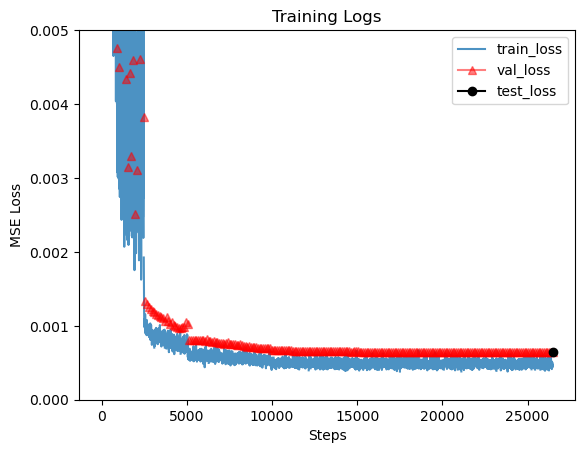

In [70]:
plot_losses(pd.read_csv(dataframe(0)), .005)

In [67]:
interact(plot_residuals, predict_input = fixed(predict_input(0)), predict_output = fixed(predict_output(0)), vessel = (0, len(predict_input(0)[0]) - 1))

interactive(children=(IntSlider(value=10, description='vessel', max=20), Output()), _dom_classes=('widget-inte…

<function __main__.plot_residuals(predict_input, predict_output, vessel)>

In [68]:
interact(plot_yhat, predict_input = fixed(predict_input(0)), predict_output = fixed(predict_output(0)), vessel = (0, len(predict_input(0)[0]) - 1))

interactive(children=(IntSlider(value=10, description='vessel', max=20), Output()), _dom_classes=('widget-inte…

<function __main__.plot_yhat(predict_input, predict_output, vessel)>

In [66]:
model_metrics(predict_output(0))

2.7% | 3.15% | 3.52% | 2.81% | 2.77% | 3.0% | 2.62% | 3.58% | 2.67% | 3.29% | 3.47% | 3.25% | 3.24% | 3.54% | 3.38% | 3.25% | 3.34% | 2.83% | 4.0% | 1.99% | 3.35% | 
Average Pressure RAE: 3.13%
2.37% | 3.18% | 3.47% | 2.64% | 2.81% | 3.02% | 2.62% | 3.58% | 2.71% | 3.28% | 3.46% | 3.27% | 3.23% | 3.53% | 3.37% | 3.24% | 3.32% | 2.84% | 4.0% | 2.0% | 3.32% | 
Average Flow RAE: 3.11%
Average Total RAE: 3.12%
